In [20]:
# Data: time-serie smartwatch or wristband or smartband data
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

# Data reading
# # Linux-Ubuntu
# data_path = '/home/arasdar/data/Training_data/DATA_01_TYPE01.mat'
# Macbook
data_path = '/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat'
watch = spio.loadmat(data_path)
data = watch['sig']
data = np.array(data)
data.shape, watch['sig'].size/6

# Normalizing each batch of the data, each batch = each file
# Can we normalize them all at the same time?
mean = np.mean(data, axis=1)
std = np.std(data, axis=1)
var = np.var(data, axis=1)
std2 = np.sqrt(var)
mean.shape, var.shape, std.shape, std2.shape, std, std2, std-std2

mean = mean.reshape(-1, 1)
std = std.reshape(-1, 1)
mean.shape, std.shape
data_norm = (data - mean)/std
data.shape, data_norm.shape
var2 = np.square(data - mean)
var2 = np.mean(var2, axis=1)
var.shape, var2.shape, var, var2, var-var2

((6,), (6,), array([  1.69625365e+04,   9.30458454e+03,   2.63488844e+04,
          3.35023841e-01,   5.98810203e-01,   5.40343592e-01]), array([  1.69625365e+04,   9.30458454e+03,   2.63488844e+04,
          3.35023841e-01,   5.98810203e-01,   5.40343592e-01]), array([ 0.,  0.,  0.,  0.,  0.,  0.]))

In [ ]:
# The features/ channels of the data = ['HR-ECG', 'HR-PPG', 'ACC-X', 'ACC-Y', 'ACC-Z']
plt.plot(data[0, :1000], label='ECG')
plt.plot(data[1, :1000], label='PPG-1')
plt.plot(data[2, :1000], label='PPG-2')
# plt.plot(x_sig[3, :1000], label='ACC-X')
# plt.plot(x_sig[4, :1000], label='SCC-Y')
# plt.plot(x_sig[5, :1000], label='ACC-Z')
plt.legend()
plt.show()

# The features/ channels of the data = ['HR-ECG', 'HR-PPG', 'ACC-X', 'ACC-Y', 'ACC-Z']
plt.plot(data_norm[0, :1000], label='ECG')
plt.plot(data_norm[1, :1000], label='PPG-1')
plt.plot(data_norm[2, :1000], label='PPG-2')
# plt.plot(x_sig[3, :1000], label='ACC-X')
# plt.plot(x_sig[4, :1000], label='SCC-Y')
# plt.plot(x_sig[5, :1000], label='ACC-Z')
plt.legend()
plt.show()

# ECG
Y = data_norm[0]
X = data_norm[1:]
Y.shape, X.shape
Y = Y.reshape(1, -1)
Y.shape, X.shape
plt.plot(Y[0, :1000], label='HR-ECG-1: Output signal')
plt.plot(X[0, :1000], label='HR-PPG-1: Input signal')
plt.plot(X[1, :1000], label='HR-PPG-2: Input signal')
plt.plot(X[2, :1000], label='ACC-X-3: Input signal')
plt.plot(X[3, :1000], label='ACC-Y-4: Input signal')
plt.plot(X[4, :1000], label='ACC-Z-5: Input signal')
plt.legend()
plt.show()
X_train = X.T
Y_train = Y.T
X_train.shape, Y_train.shape

# Preparing the training data for seq2seq learning
Y_train_in = Y_train[:-2]
Y_train_out = Y_train[:-1]
#     Y_train_in.shape, Y_train.shape
firstrow = np.zeros([1, 1])
#     firstrow.shape, Y_train_in.shape
Y_train_in = np.row_stack((firstrow, Y_train_in))
#     Y_train_in.shape, Y_train_in[:5], Y_train[:5]
#     Y_train_out = Y_train.copy()
X_train.shape, Y_train_in.shape, Y_train_out.shape
XY_train = (X_train, Y_train)

# Read and normalize one batch/file of data
def read_data(data_path):
    band = spio.loadmat(data_path)
    data = band['sig']
    data = np.array(data)
    #     data.shape, band['sig'].size/6

    # Normalizing each batch of the data, each batch = each file
    # Can we normalize them all at the same time?
    mean = np.mean(data, axis=1)
    var = np.var(data, axis=1)
    std = np.sqrt(var)
    mean.shape, var.shape, std.shape
    mean = mean.reshape(-1, 1)
    std = std.reshape(-1, 1)
    mean.shape, std.shape
    data_norm = (data - mean)/std
    #     print(data.shape, data_norm.shape)
    
    # ECG
    Y = data_norm[0]
    # PPG+ACC
    X = data_norm[1:]
    # Y.shape, X.shape
    Y = Y.reshape(1, -1)
    # Y.shape, X.shape
    X_train = X.T
    Y_train = Y.T
    #     print(X_train.shape, Y_train.shape)
    
    return X_train, Y_train

In [ ]:
# Model or Network
import impl.layer as l

class GRU:

    def __init__(self, D, C, H, L, p_dropout):
        self.D = D # number of input dimensions
        self.H = H # number of hidden units
        self.L = L # number of hidden layers
        self.C = C # number of output classes/dimensions
        self.losses = {'train':[], 'train2':[], 'train3':[]} #, 'valid':[], 'test':[]
        
        # Input sequence model parameters
        Z = H + D
        params_in_seq = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(D / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        # This is the last layer in the input mode
        params_in_seq_ = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H))
        )
        
        # Output sequence model parameters
        Z = H + C
        params_out_seq = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, C) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, C))
        )

        # Model parameters
        self.model = []
        num_modes = 2 # num of modality as the source of sequences
        for _ in range(num_modes):
            self.model.append([])
        
        for _ in range(self.L-1):
            self.model[0].append(params_in_seq)

        # The last layer: self.L-1
        self.model[0].append(params_in_seq_)
        
        # Number of layers for each mode
        for _ in range(self.L):
            self.model[1].append(params_out_seq)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    # keep_prob = 1 - p_dropout, q = 1 - p
    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        u = cache
        dX = dout * u
        return dX

    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX
    
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = mask * h + (1 - mask) * alpha_p
        a = 1. / np.sqrt(q + alpha_p ** 2 * q  * (1 - q))
        b = -a * (1 - q) * alpha_p
        out = a * dropped + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_one_hot = X.copy()
        h_old = h.copy()

        X = np.column_stack((h_old, X_one_hot))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X_prime = np.column_stack((hr * h_old, X_one_hot))
        hh, hh_cache = l.fc_forward(X_prime, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # The final output
        h = (1. - hz) * h_old + hz * hh
        y, y_cache = l.fc_forward(h, Wy, by)
        cache = (X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache,
                 hh, hh_cache, hh_tanh_cache, h, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, h, y_cache = cache
        
        dh_next = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dhh = hz * dh
        dh_old1 = (1. - hz) * dh
        dhz = hh * dh - h_old * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX_prime, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh_prime = dX_prime[:, :self.H]
        dh_old2 = hr * dh_prime

        dhr = h_old * dh_prime
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_old3 = dX[:, :self.H]

        # The final output
        dh = dh_old1 + dh_old2 + dh_old3
        dX = dX[:, self.H:]
        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def forward_(self, X, h, m):
        Wz, Wr, Wh = m['Wz'], m['Wr'], m['Wh']
        bz, br, bh = m['bz'], m['br'], m['bh']

        X_one_hot = X.copy()
        h_old = h.copy()

        X = np.column_stack((h_old, X_one_hot))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X_prime = np.column_stack((hr * h_old, X_one_hot))
        hh, hh_cache = l.fc_forward(X_prime, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # The output
        h = (1. - hz) * h_old + hz * hh
        cache = (X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache,
                 hh, hh_cache, hh_tanh_cache)

        return h, cache

    def backward_(self, dh, cache):
        X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache = cache
        
        dhh = hz * dh
        dh_old1 = (1. - hz) * dh
        dhz = hh * dh - h_old * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX_prime, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh_prime = dX_prime[:, :self.H]
        dh_old2 = hr * dh_prime

        dhr = h_old * dh_prime
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_old3 = dX[:, :self.H]

        # The final output
        dh = dh_old1 + dh_old2 + dh_old3
        dX = dX[:, self.H:]
        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, bz=dbz, br=dbr, bh=dbh)
        
        return dX, dh, grad
    
    def train_forward(self, XY_train, h):
        # Adding the output layer cache
        caches = []
        num_modes = 2
        for _ in range(num_modes):
            caches.append([])
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches[0].append([])
            caches[1].append([])
            
        ys = []
        X, Y = XY_train
        
        # Input sequence
        for x in X:
            #             print(x.shape)
            x= x.reshape(1, -1) # mat_1xn
            #             print(x.shape)
            
            for layer in range(self.L-1):
                x, h[layer], cache = self.forward(x, h[layer], self.model[0][layer])
                caches[0][layer].append(cache)
            
            # The last layer without output
            layer = self.L - 1
            h[layer], cache = self.forward_(x, h[layer], self.model[0][layer])
            caches[0][layer].append(cache)
            
        # Output sequence
        for y in Y:
            #             print(y.shape)
            y= y.reshape(1, -1) # mat_1xn
            #             print(y.shape)
            
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[1][layer])
                caches[1][layer].append(cache)

            # Output list
            ys.append(y)
            
        return ys, caches

    def l2_regression(self, y_pred, y_train):
        m = y_pred.shape[0]
        #         print('y_pred.shape[0]', m)

        # (F(x)-y)^2: convex as X^2 or (aX-b)^2
        data_loss = 0.5 * np.sum((y_pred - y_train)**2) / m # number of dimensions
    
        return data_loss

    def dl2_regression(self, y_pred, y_train):
        m = y_pred.shape[0]
        #         print('y_pred.shape[0]', m)

        # (F(x)-y)^2: convex as X^2 or (aX-b)^2
        dy = (y_pred - y_train)/ m # number of dimensions

        return dy

    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []
        #         m = y_train.shape[0]
        #         print('y_train.shape[0]', m)
        #         print('len(y_pred):', len(y_pred))
        #         print('np.array(y_pred).shape:', np.array(y_pred).shape)
        #         print('y_train.shape:', y_train.shape)

        for y, Y in zip(y_pred, y_train):
            loss += self.l2_regression(y_pred=y, y_train=Y) #/ m # t or number of samples for taking the average
            dy = self.dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        num_modes = 2
        for _ in range(num_modes):
            grad.append([])
            grads.append([])
        
        for _ in range(self.L):
            dh.append(np.zeros((1, self.H)))
            
        for mode in range(num_modes):
            for layer in range(self.L):
                grad[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})
                grads[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})

        # Output sequence
        mode = 1
        for t in reversed(range(len(dys))):
            dX = dys[t].copy()
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[mode][layer] = self.backward(dX, dh[layer], caches[mode][layer][t])
                for key in grad[mode][layer].keys():
                    grads[mode][layer][key] += grad[mode][layer][key]

        # Input sequence
        mode = 0
        for t in reversed(range(len(dys))):
            # Output layer or last layer
            layer = self.L-1
            dX, dh[layer], grad[mode][layer] = self.backward_(dh[layer], caches[mode][layer][t])
            for key in grad[mode][layer].keys():
                grads[mode][layer][key] += grad[mode][layer][key]

            # The depth and number of layers for RNN
            for layer in reversed(range(self.L-1)):
                dX, dh[layer], grad[mode][layer] = self.backward(dX, dh[layer], caches[mode][layer][t])
                for k in grad[mode][layer].keys():
                    grads[mode][layer][k] += grad[mode][layer][k]

        return dX, grads

In [2]:
def get_minibatch(X, Y, minibatch_size): # shuffle: this is for static data not dynamic/sequential data
    minibatches = []
    
    # for i in range(start=0, stop=X.shape[0], step=minibatch_size):
    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        Y_mini = Y[i:i + minibatch_size]
        minibatches.append((X_mini, Y_mini))

    return minibatches

def adam_rnn(nn, alpha, mb_size, n_iter, print_after, n_files):
    M, R = [], []
    num_modes = 2
    for _ in range(num_modes):
        M.append([])
        R.append([])

    for mode in range(num_modes):
        for layer in range(nn.L):
            M[mode].append({k: np.zeros_like(v) for k, v in nn.model[mode][layer].items()})
            R[mode].append({k: np.zeros_like(v) for k, v in nn.model[mode][layer].items()})

    beta1 = .9
    beta2 = .99
    state = nn.initial_state()
    #     import impl.constant as c, c.eps
    eps = 1e-8 # constant

    
    # Epochs
    for iter in range(1, n_iter + 1):
        
        # Read the new file, normalize it, and separate it into input and target
        for file_num in range(1, n_files + 1):
            
#             if file_num == 1: data_path = '/Users/arasdar/data/Training_data/DATA_{:02}_TYPE01.mat'.format(file_num)
#             else: data_path = '/Users/arasdar/data/Training_data/DATA_{:02}_TYPE02.mat'.format(file_num)
            if file_num == 1: data_path = '/home/arasdar/data/Training_data/DATA_{:02}_TYPE01.mat'.format(file_num)
            else: data_path = '/home/arasdar/data/Training_data/DATA_{:02}_TYPE02.mat'.format(file_num)
            print(data_path)

            # Read the mat files, normalize each batch of them, and seperate the output and input
            X_train, Y_train = read_data(data_path=data_path)
            #             X_train, Y_train_in = XY_train
            #             print(X_train.shape, Y_train_in.shape, Y_train_out.shape)

            # Minibatches/ Stochasticity
            #             minibatches = get_minibatch(X_train, Y_train, mb_size, shuffle=False)
            minibatches = get_minibatch(X=X_train, Y=Y_train, minibatch_size=mb_size) #, shuffle=False
            #             print('The number of minibatches in a sequence for each epoch iteration: {}'.format (len(minibatches)))

            # Minibatches/ Stochasticity
            #             print('The number of minibatches in a sequence for each epoch iteration: {}'.format (len(minibatches)))
            for idx in range(len(minibatches)):
                
                # Gradients
                X_mini, Y_mini = minibatches[idx]
                Y_mini_out = Y_mini[:-1] # mat[t, n]== mat_txn
                Y_mini_in = np.row_stack((np.array([0.0]), Y_mini[:-2]))
                #                 print(X_mini.shape, Y_mini.shape, Y_mini_out.shape)
                print(X_mini[:4], Y_mini_in[:4], Y_mini_out[:4])
                #                 print(Y_mini[:4], Y_mini_out[:4])
                #             print(nn.model[0][0]['Wz'].shape, nn.model[1][0]['Wz'].shape, nn.C, nn.D)
                #             print(nn.model[0][0]['Wr'].shape, nn.model[1][0]['Wh'].shape, nn.C, nn.D)

                XY_mini = (X_mini, Y_mini_in)
                ys, caches = nn.train_forward(XY_mini, state)
                loss, dys = nn.loss_function(y_train=Y_mini_out, y_pred=ys)
                _, grads = nn.train_backward(dys, caches)

                # Descend
                for mode in range(num_modes):
                    for layer in range(nn.L):
                        for key in grads[mode][layer].keys(): #key, value: items
                            M[mode][layer][key] = l.exp_running_avg(M[mode][layer][key], grads[mode][layer][key], beta1)
                            R[mode][layer][key] = l.exp_running_avg(R[mode][layer][key], grads[mode][layer][key]**2, beta2)

                            m_k_hat = M[mode][layer][key] / (1. - (beta1**(iter)))
                            r_k_hat = R[mode][layer][key] / (1. - (beta2**(iter)))

                            nn.model[mode][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
                            
                # MiniBatches: Drawing the learning curve for loss (Error/loss curve)
                nn.losses['train'].append(loss)
                
            # FullBatches: Drawing the learning curve for loss (Error/loss curve)
            # (based on batch normalization/bn at the input layer)
            nn.losses['train2'].append(loss)
            
        # Epochs: Drawing the learning curve for loss (Error/loss curve)
        nn.losses['train3'].append(loss)
            
        # Print training loss
        if iter % print_after == 0:
            print('Iter-{} training loss: {:.4f}'.format(iter, loss))
                
    return nn

In [ ]:
# hyper parameters
n_iter = 1 # epochs: processing speed and how much time it takes.
n_files = 1 # dataset size: maximum number of files in dataset based on 12 subjects
print_after = n_iter//10 # print loss of train, valid, and test
time_step = 200 # width of the model or minibatch size
alpha = 1/time_step # learning_rate: 1e-3=0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 1 # depth or number of hidden layer
num_input_units = X_train.shape[1] # number of input features/dimensions
num_output_units = Y_train.shape[1]
# X_train.shape, Y_train.shape

net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

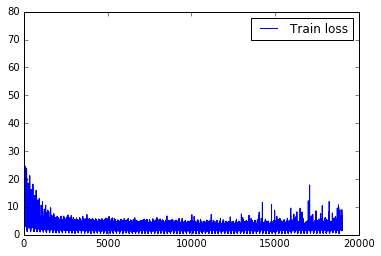

In [30]:
# Display the learning curve and losses for training, validation, and testing
# % matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['train2'], label='Train loss2')
# plt.plot(net.losses['train3'], label='Train loss3')
plt.legend()
plt.show()